# Continuous Control

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the second project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name='Reacher_multiple/Reacher.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		goal_size -> 5.0
		goal_speed -> 1.0
Unity brain name: ReacherBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 33
        Number of stacked Vector Observation: 1
        Vector Action space type: continuous
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Reacher.app"`
- **Windows** (x86): `"path/to/Reacher_Windows_x86/Reacher.exe"`
- **Windows** (x86_64): `"path/to/Reacher_Windows_x86_64/Reacher.exe"`
- **Linux** (x86): `"path/to/Reacher_Linux/Reacher.x86"`
- **Linux** (x86_64): `"path/to/Reacher_Linux/Reacher.x86_64"`
- **Linux** (x86, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86"`
- **Linux** (x86_64, headless): `"path/to/Reacher_Linux_NoVis/Reacher.x86_64"`

For instance, if you are using a Mac, then you downloaded `Reacher.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Reacher.app")
```

Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [2]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, a double-jointed arm can move to target locations. A reward of `+0.1` is provided for each step that the agent's hand is in the goal location. Thus, the goal of your agent is to maintain its position at the target location for as many time steps as possible.

The observation space consists of `33` variables corresponding to position, rotation, velocity, and angular velocities of the arm.  Each action is a vector with four numbers, corresponding to torque applicable to two joints.  Every entry in the action vector must be a number between `-1` and `1`.

Run the code cell below to print some information about the environment.

In [3]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 20
Size of each action: 4
There are 20 agents. Each observes a state with length: 33
The state for the first agent looks like: [ 0.00000000e+00 -4.00000000e+00  0.00000000e+00  1.00000000e+00
 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00 -1.00000000e+01  0.00000000e+00
  1.00000000e+00 -0.00000000e+00 -0.00000000e+00 -4.37113883e-08
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  5.75471878e+00 -1.00000000e+00
  5.55726624e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00
 -1.68164849e-01]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agent and receive feedback from the environment.

Once this cell is executed, you will watch the agent's performance, if it selects an action at random with each time step.  A window should pop up that allows you to observe the agent, as it moves through the environment.  

Of course, as part of the project, you'll have to change the code so that the agent is able to use its experience to gradually choose better actions when interacting with the environment!

In [ ]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
    actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

When finished, you can close the environment.

In [ ]:
env.close()

### 4. It's Your Turn!

Now it's your turn to train your own agent to solve the environment!  When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```

In [4]:
import random
import numpy as np
import torch
import torch.optim as optim
import torch.nn.functional as F
from models import Actor, Critic
from replay_buffer import ReplayBuffer
from ou_noise import OUNoise
from collections import deque


BUFFER_SIZE = int(1e6)  # replay buffer size
BATCH_SIZE = 128         # minibatch size
GAMMA = 0.99            # discount factor
TAU = 1e-3              # for soft update of target parameters
ACTOR_LR = 1e-4
CRITIC_LR = 1e-3
UPDATE_EVERY = 20        # how often to update the network
UPDATES_NUM = 10
PICK_BEST_NUM = 5


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


class Agent():
    """Interacts with and learns from the environment."""
    def __init__(self, state_size, action_size, seed):
        """Initialize an Agent object.
        
        Params
        ======
            state_size (int): dimension of each state
            action_size (int): dimension of each action
        """
        self.state_size = state_size
        self.action_size = action_size
        self.seed = seed
        
        self.actor_local = Actor(state_size, action_size, seed).to(device)
        self.actor_target = Actor(state_size, action_size, seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr=ACTOR_LR)
        
        self.critic_local = Critic(state_size, action_size, seed).to(device)
        self.critic_target = Critic(state_size, action_size, seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr=CRITIC_LR)
            
        self.noise = OUNoise(action_size)
        
        # Initialize time step (for updating every UPDATE_EVERY steps)
        self.t_step = 0
    
    
    def soft_update(self, target, src):
        for target_param, param in zip(target.parameters(), src.parameters()):
            target_param.detach_()
            target_param.copy_(target_param * (1.0 - TAU) +
                               param * TAU)
    
    
    def step(self, replay_buffer, state, action, reward, next_state, done):
        self.t_step += 1
        
        if len(replay_buffer) < 1e4:
            return
        
        # Learn every UPDATE_EVERY time steps.
        if self.t_step % UPDATE_EVERY == 0:
            for i in range(UPDATES_NUM):
                experiences = replay_buffer.sample()
                self.learn(experiences, GAMMA)

    
    def reset(self):
        self.noise.reset()
    
                
    def act(self, state, noisy = True):
        """Returns actions for given state as per current policy.
        
        Params
        ======
            state (array_like): current state

        """
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if noisy:
            action += self.noise.sample()
        return np.clip(action, -1, 1)
    

    def learn(self, experiences, gamma):
        """Update value parameters using given batch of experience tuples.

        Params
        ======
            experiences (Tuple[torch.Variable]): tuple of (s, a, r, s', done) tuples 
            gamma (float): discount factor
        """
        states, actions, rewards, next_states, dones = experiences
        
        if dones[0]:
            self.noise.reset()
        
        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)
        # Compute Q targets for current states (y_i)
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        self.soft_update(self.critic_target, self.critic_local)
        self.soft_update(self.actor_target, self.actor_local)

## Agent training

In [5]:
agents = [Agent(state_size, action_size, 4) for i in range(num_agents)]

In [6]:
def ddpg(agents, n_episodes=50000, max_t=1000):
    """Deep Q-Learning.
    
    Params
    ======
        n_episodes (int): maximum number of training episodes
        max_t (int): maximum number of timesteps per episode
        eps_start (float): starting value of epsilon, for epsilon-greedy action selection
        eps_end (float): minimum value of epsilon
        eps_decay (float): multiplicative factor (per episode) for decreasing epsilon
    """ 
    agents_scores = []                     # list containing scores from each episode
    scores_window = deque(maxlen=100)  # last 100 scores
    
    replay_buffer = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, device)
    max_score = 0
    best_agent = agents[0]
    
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        for agent in agents:
            agent.reset()
        states = env_info.vector_observations
        scores = np.zeros(num_agents)
        for t in range(max_t):
            actions = []
            for agent, state in zip(agents, states):
                actions.append(agent.act(state))
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done
            for agent, state, action, reward, next_state, done in zip(agents,
                states, actions, rewards, next_states, dones):
                replay_buffer.add(state, action, reward, next_state, done)
                agent.step(replay_buffer, state, action, reward, next_state, done)
            states = next_states
            scores += rewards
            if np.any(dones):
                break 
        scores_window.append(np.mean(scores))
        agents_scores.append(np.mean(scores))             # save most recent score
        avg_score = np.mean(scores_window)
        best_score = max(scores)
        print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}\t Best score: {best_score:.2f}', end="")
        if best_score > max_score:
            best_agent = agents[np.argmax(scores)]
            agents = [best_agent for i in range(num_agents)]
            max_score = best_score
        if i_episode % 100 == 0:
            print(f'\rEpisode {i_episode}\tAverage Score: {avg_score:.2f}\t Best score: {best_score:.2f}')
            torch.save(best_agent.actor_local.state_dict(), f'checkpoint_actor_{i_episode}.pth')
            torch.save(best_agent.critic_local.state_dict(), f'checkpoint_critic_{i_episode}.pth')
        if np.mean(scores_window)>=30. and i_episode >= 100:
            print(f'\nEnvironment solved in {i_episode} episodes!\tAverage Score: {avg_score:.2f}')
            torch.save(best_agent.actor_local.state_dict(), 'checkpoint_actor_done.pth')
            torch.save(best_agent.critic_local.state_dict(), 'checkpoint_critic_done.pth')
            break
    return agents_scores

scores = ddpg(agents)

Episode 100	Average Score: 26.79	 Best score: 39.41
Episode 110	Average Score: 30.02	 Best score: 39.49
Environment solved in 110 episodes!	Average Score: 30.02


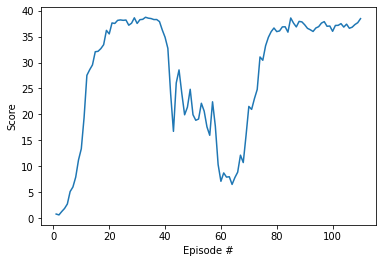

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

## Agent evaluation

In [5]:
agents_learned = [Agent(state_size, action_size, 4) for i in range(num_agents)]
for agent in agents_learned:
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_done.pth'))

In [6]:
env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
states = env_info.vector_observations                  # get the current state (for each agent)
scores = np.zeros(num_agents)                          # initialize the score (for each agent)
while True:
    actions = []
    for agent, state in zip(agents_learned, states):   # select an action (for each agent)
        actions.append(agent.act(state, noisy = False))
    env_info = env.step(actions)[brain_name]           # send all actions to tne environment
    next_states = env_info.vector_observations         # get next state (for each agent)
    rewards = env_info.rewards                         # get reward (for each agent)
    dones = env_info.local_done                        # see if episode finished
    scores += env_info.rewards                         # update the score (for each agent)
    states = next_states                               # roll over states to next time step
    if np.any(dones):                                  # exit loop if episode finished
        break
print('Total score (averaged over agents) this episode: {}'.format(np.mean(scores)))

Total score (averaged over agents) this episode: 38.50299913939089


In [ ]:
env.close()